## [Materials](https://www.youtube.com/watch?v=CbTU92pbDKw&ab_channel=GregHogg)
MSFT Stock data from [Yahoo Finance](https://finance.yahoo.com/quote/MSFT/history?period1=511056000&period2=1700524800&interval=1d&filter=history&frequency=1d&includeAdjustedClose=true)

## Load Helper Library

In [1]:
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import numpy as np

## Load data

In [2]:
data = pd.read_csv("./Data/MSFT.csv")
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1986-03-13,0.088542,0.101563,0.088542,0.097222,0.060274,1031788800
1,1986-03-14,0.097222,0.102431,0.097222,0.100694,0.062427,308160000
2,1986-03-17,0.100694,0.103299,0.100694,0.102431,0.063504,133171200
3,1986-03-18,0.102431,0.103299,0.098958,0.099826,0.061889,67766400
4,1986-03-19,0.099826,0.100694,0.097222,0.098090,0.060812,47894400


In [3]:
df_clean = data[["Date","Close"]]
df_clean.head()

,Date,Close
0,1986-03-13,0.097222
1,1986-03-14,0.100694
2,1986-03-17,0.102431
3,1986-03-18,0.099826
4,1986-03-19,0.098090


## Data Processing
### Parse datetime data

In [4]:
def str_to_datetime(s):
    year,month,day = str(s).split("-")
    return datetime.datetime(year = int(year),month= int(month),day = int(day))


str_to_datetime(df_clean['Date'][0])

datetime.datetime(1986, 3, 13, 0, 0)

In [5]:
df_clean['Datetime'] = df_clean['Date'].apply(str_to_datetime)
df_clean['Datetime'][:5]

C:\Users\yyang\AppData\Local\Temp\ipykernel_7664\958298037.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['Datetime'] = df_clean['Date'].apply(str_to_datetime)


0   1986-03-13
1   1986-03-14
2   1986-03-17
3   1986-03-18
4   1986-03-19
Name: Datetime, dtype: datetime64[ns]

In [6]:
df_clean.index = df_clean.pop('Datetime')
df_clean.head()

,Date,Close
Datetime,,
1986-03-13,1986-03-13,0.097222
1986-03-14,1986-03-14,0.100694
1986-03-17,1986-03-17,0.102431
1986-03-18,1986-03-18,0.099826
1986-03-19,1986-03-19,0.098090


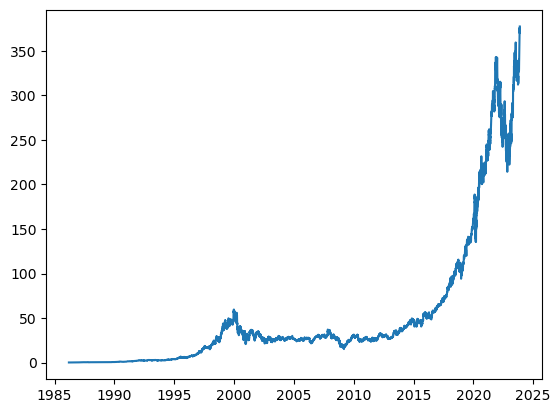

In [7]:
plt.plot(df_clean.index,df_clean['Close'])

## Create Windowed Data

In [8]:
def df_to_windowed_df(df, first_date_str, last_date_str, n=3):
    ## Get start date and end date
    first_date = str_to_datetime(first_date_str)
    last_date  = str_to_datetime(last_date_str)
    
    ## Initial target date as start date
    target_date = first_date
    
    dates = []
    X,Y = [],[]
    
    last_time = False
    while True:
        ## Pick n+1 dates from the bottom of df
        df_subset = df.loc[:target_date].tail(n+1)
        
        if len(df_subset) != n+1:
            print(f'Error: Window of size {n} is too large for date {target_date}')
            return
        
        values = df_subset['Close'].to_numpy()
        x, y = values[:-1], values[-1]
        
        dates.append(target_date)
        X.append(x)
        Y.append(y)
        
        next_week = df.loc[target_date:target_date+datetime.timedelta(days=7)]
        next_datetime_str = str(next_week.head(2).tail(1).index.values[0])
        next_date_str = next_datetime_str.split('T')[0]
        year_month_day = next_date_str.split('-')
        year, month, day = year_month_day
        next_date = datetime.datetime(day=int(day), month=int(month), year=int(year))
        
        if last_time:
            break
            
        target_date = next_date

        if target_date == last_date:
            last_time = True
            
    ret_df = pd.DataFrame({})
    ret_df['Target Date'] = dates
    
    X = np.array(X)
    for i in range(0, n):
        X[:, i]
        ret_df[f'Target-{n-i}'] = X[:, i]
    
    ret_df['Target'] = Y

    return ret_df


#### Use the previous 3 days data to predict target price

In [9]:
# Start day second time around: '2020-03-25'
windowed_df = df_to_windowed_df(df_clean[['Close']], 
                                '2020-03-25', 
                                '2023-11-20', 
                                n=5)

windowed_df.head()

,Target Date,Target-5,Target-4,Target-3,Target-2,Target-1,Target
0,2020-03-25,140.399994,142.710007,137.350006,135.979996,148.339996,146.919998
1,2020-03-26,142.710007,137.350006,135.979996,148.339996,146.919998,156.110001
2,2020-03-27,137.350006,135.979996,148.339996,146.919998,156.110001,149.699997
3,2020-03-30,135.979996,148.339996,146.919998,156.110001,149.699997,160.229996
4,2020-03-31,148.339996,146.919998,156.110001,149.699997,160.229996,157.710007


### Convert to numpy array

In [10]:
def windowed_df_to_date_X_y(windowed_df):
    df_as_np = windowed_df.to_numpy()
    
    dates = df_as_np[:,0]  # get first col
    
    middle_matrix = df_as_np[:,1:-1] # get all X (except date and target)
    X = middle_matrix.reshape((len(dates),middle_matrix.shape[1],1))
    
    Y = df_as_np[:,-1]
    return dates, X.astype(np.float32), Y.astype(np.float32)

In [11]:
dates, X, y = windowed_df_to_date_X_y(windowed_df=windowed_df)
dates.shape, X.shape, y.shape 

((922,), (922, 5, 1), (922,))

## Model Build
### Training Testing split
0% - 80% as training, 80% - 90% as validation, 90% - 100% as testing

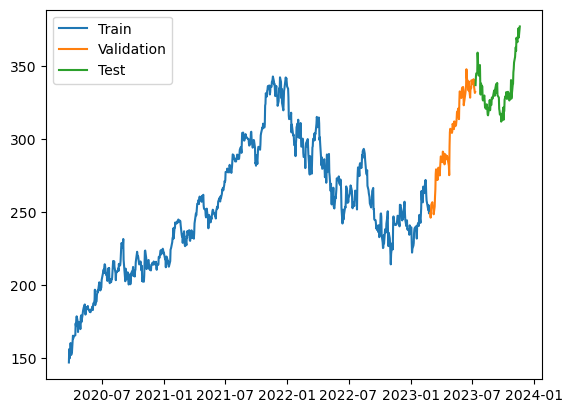

In [12]:
q_80 = int(len(dates) * .8)
q_90 = int(len(dates) * .9)

dates_train, X_train, y_train = dates[:q_80], X[:q_80], y[:q_80]

dates_val, X_val, y_val = dates[q_80:q_90], X[q_80:q_90], y[q_80:q_90]
dates_test, X_test, y_test = dates[q_90:], X[q_90:], y[q_90:]

plt.plot(dates_train,y_train)
plt.plot(dates_val,y_val)
plt.plot(dates_test,y_test)

plt.legend(['Train','Validation','Test'])
plt.show()

### Build model

In [13]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers

In [14]:
model = Sequential([layers.Input((5, 1)),
                    layers.LSTM(64),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(1)])

model.compile(loss='mse', 
              optimizer=Adam(learning_rate=0.001),
              metrics=['mean_absolute_error'])

model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100)

Epoch 1/100
24/24 [==============================] - 3s 22ms/step - loss: 64700.7969 - mean_absolute_error: 250.8540 - val_loss: 90639.2266 - val_mean_absolute_error: 299.7093
Epoch 2/100
24/24 [==============================] - 0s 5ms/step - loss: 62909.3477 - mean_absolute_error: 247.2332 - val_loss: 87260.4141 - val_mean_absolute_error: 294.0069
Epoch 3/100
24/24 [==============================] - 0s 5ms/step - loss: 58325.8984 - mean_absolute_error: 237.7573 - val_loss: 79421.5938 - val_mean_absolute_error: 280.3708
Epoch 4/100
24/24 [==============================] - 0s 5ms/step - loss: 50302.2539 - mean_absolute_error: 220.2361 - val_loss: 66288.1172 - val_mean_absolute_error: 255.8769
Epoch 5/100
24/24 [==============================] - 0s 5ms/step - loss: 36923.7109 - mean_absolute_error: 187.1199 - val_loss: 46130.1641 - val_mean_absolute_error: 212.8674
Epoch 6/100
24/24 [==============================] - 0s 5ms/step - loss: 20537.5977 - mean_absolute_error: 135.8048 - val_lo

### Visualize Results

24/24 [==============================] - 0s 2ms/step


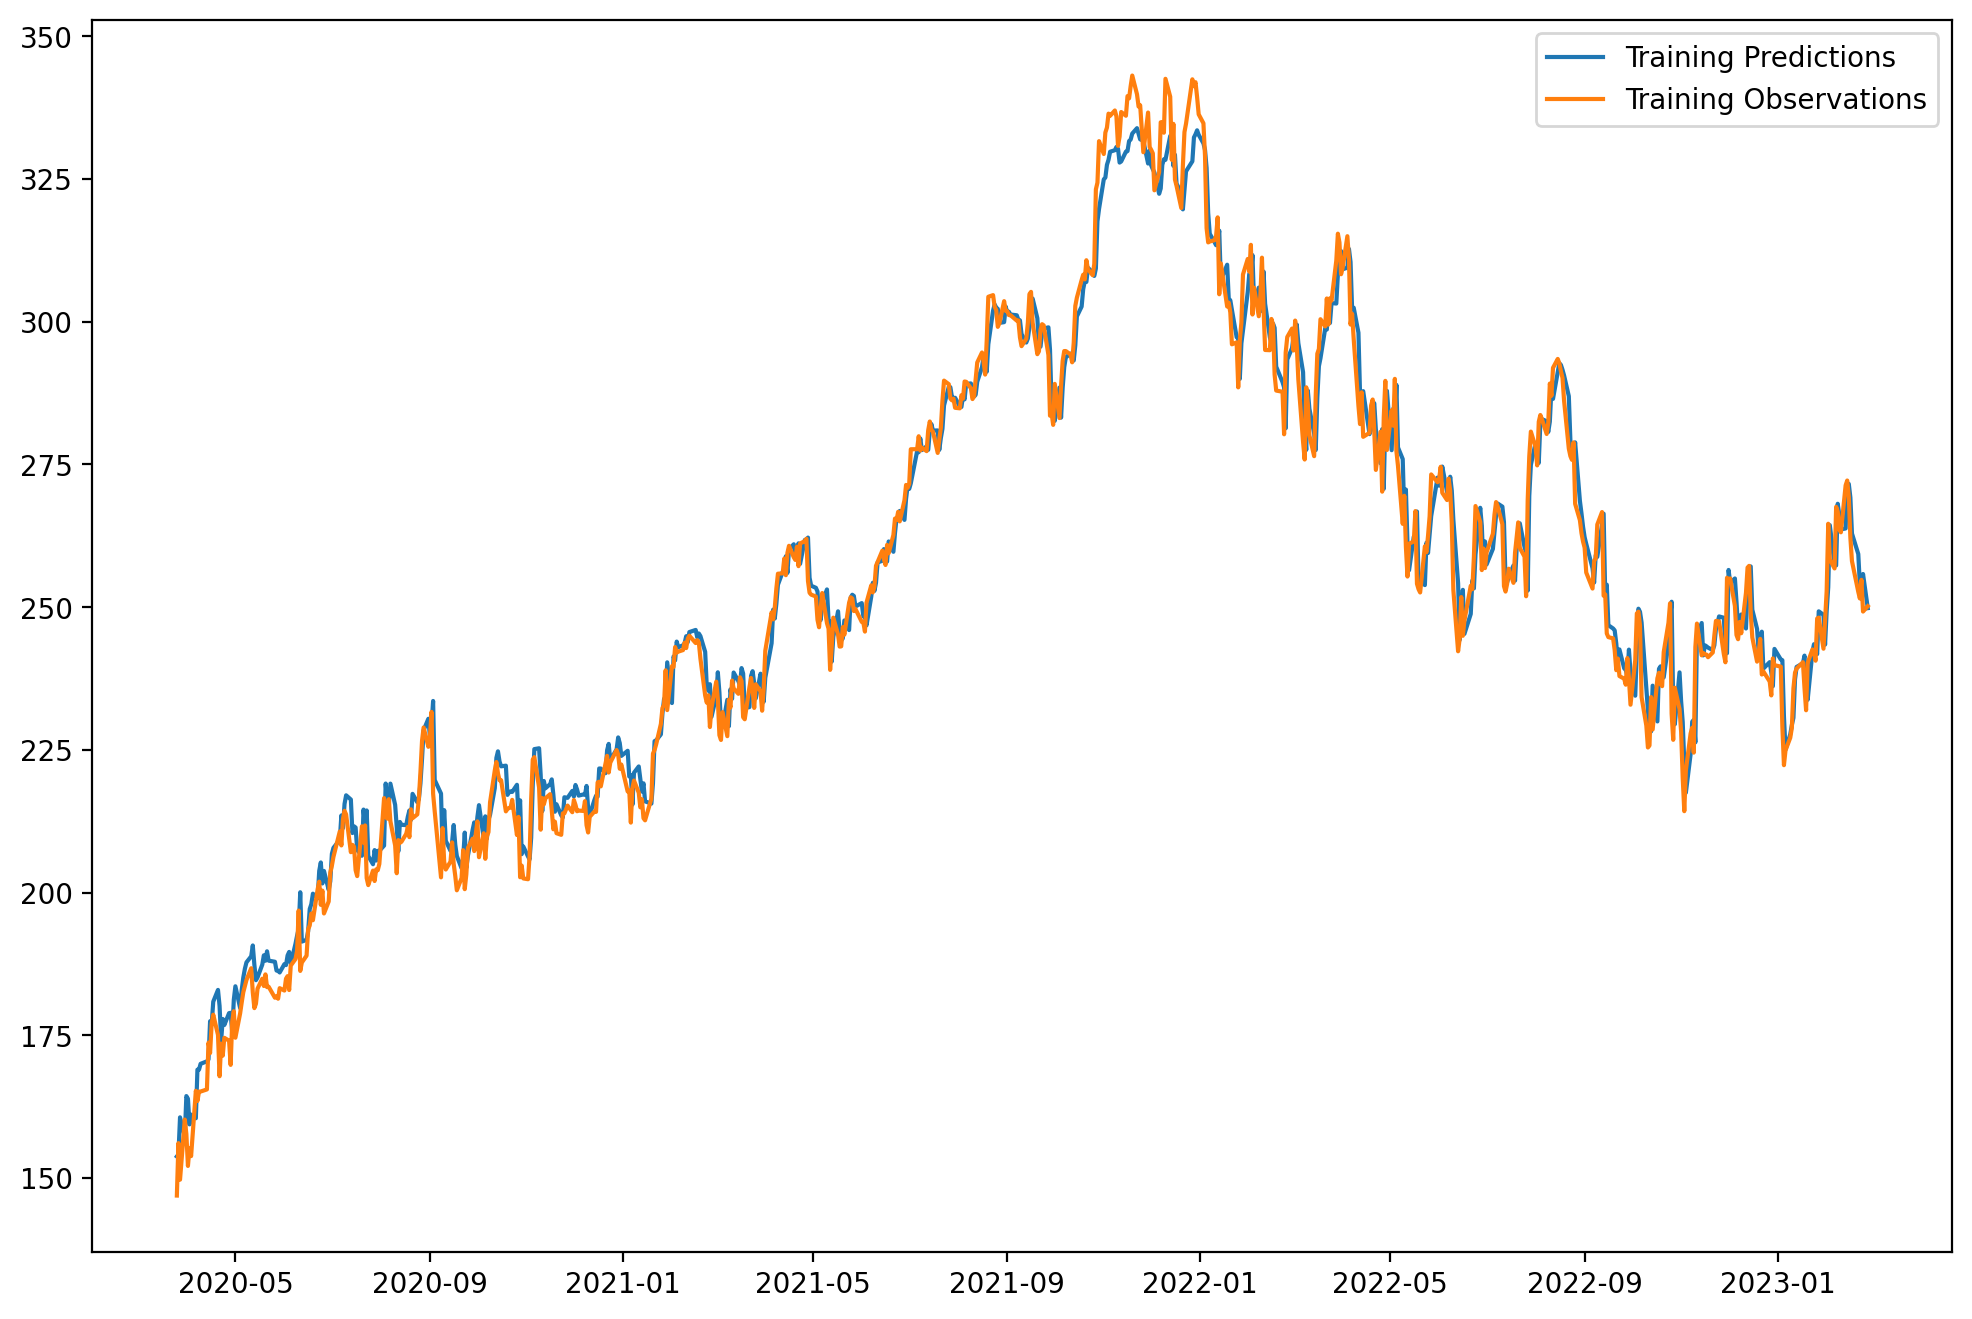

In [15]:
train_predictions = model.predict(X_train).flatten()

plt.figure(figsize=(12, 8), dpi=200)
plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.legend(['Training Predictions', 'Training Observations'])

3/3 [==============================] - 0s 2ms/step


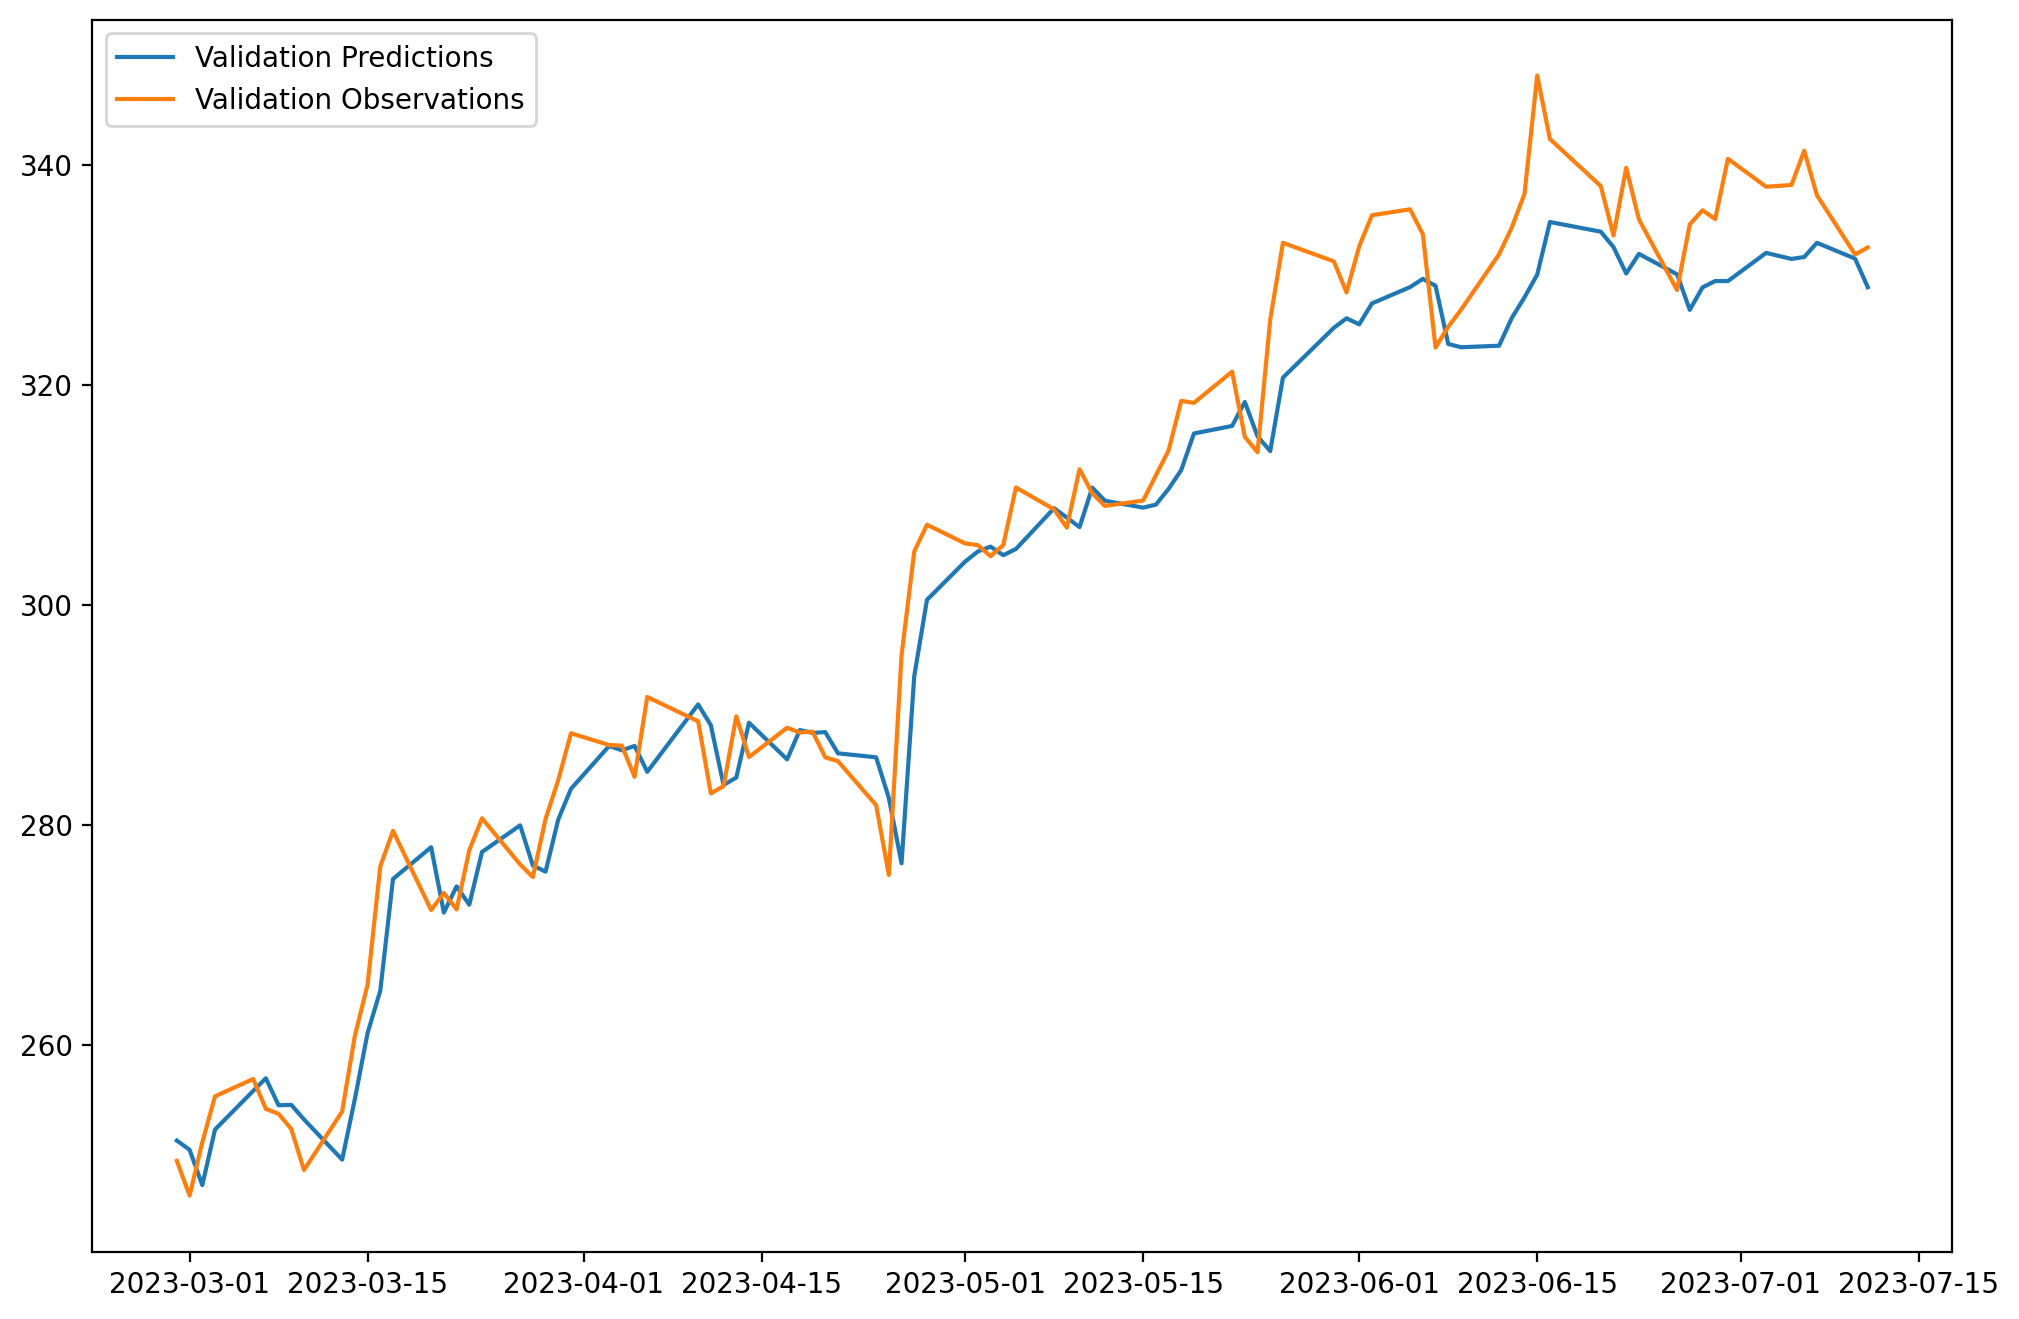

In [16]:
val_predictions = model.predict(X_val).flatten()

plt.figure(figsize=(12, 8), dpi=200)
plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.legend(['Validation Predictions', 'Validation Observations'])

3/3 [==============================] - 0s 3ms/step


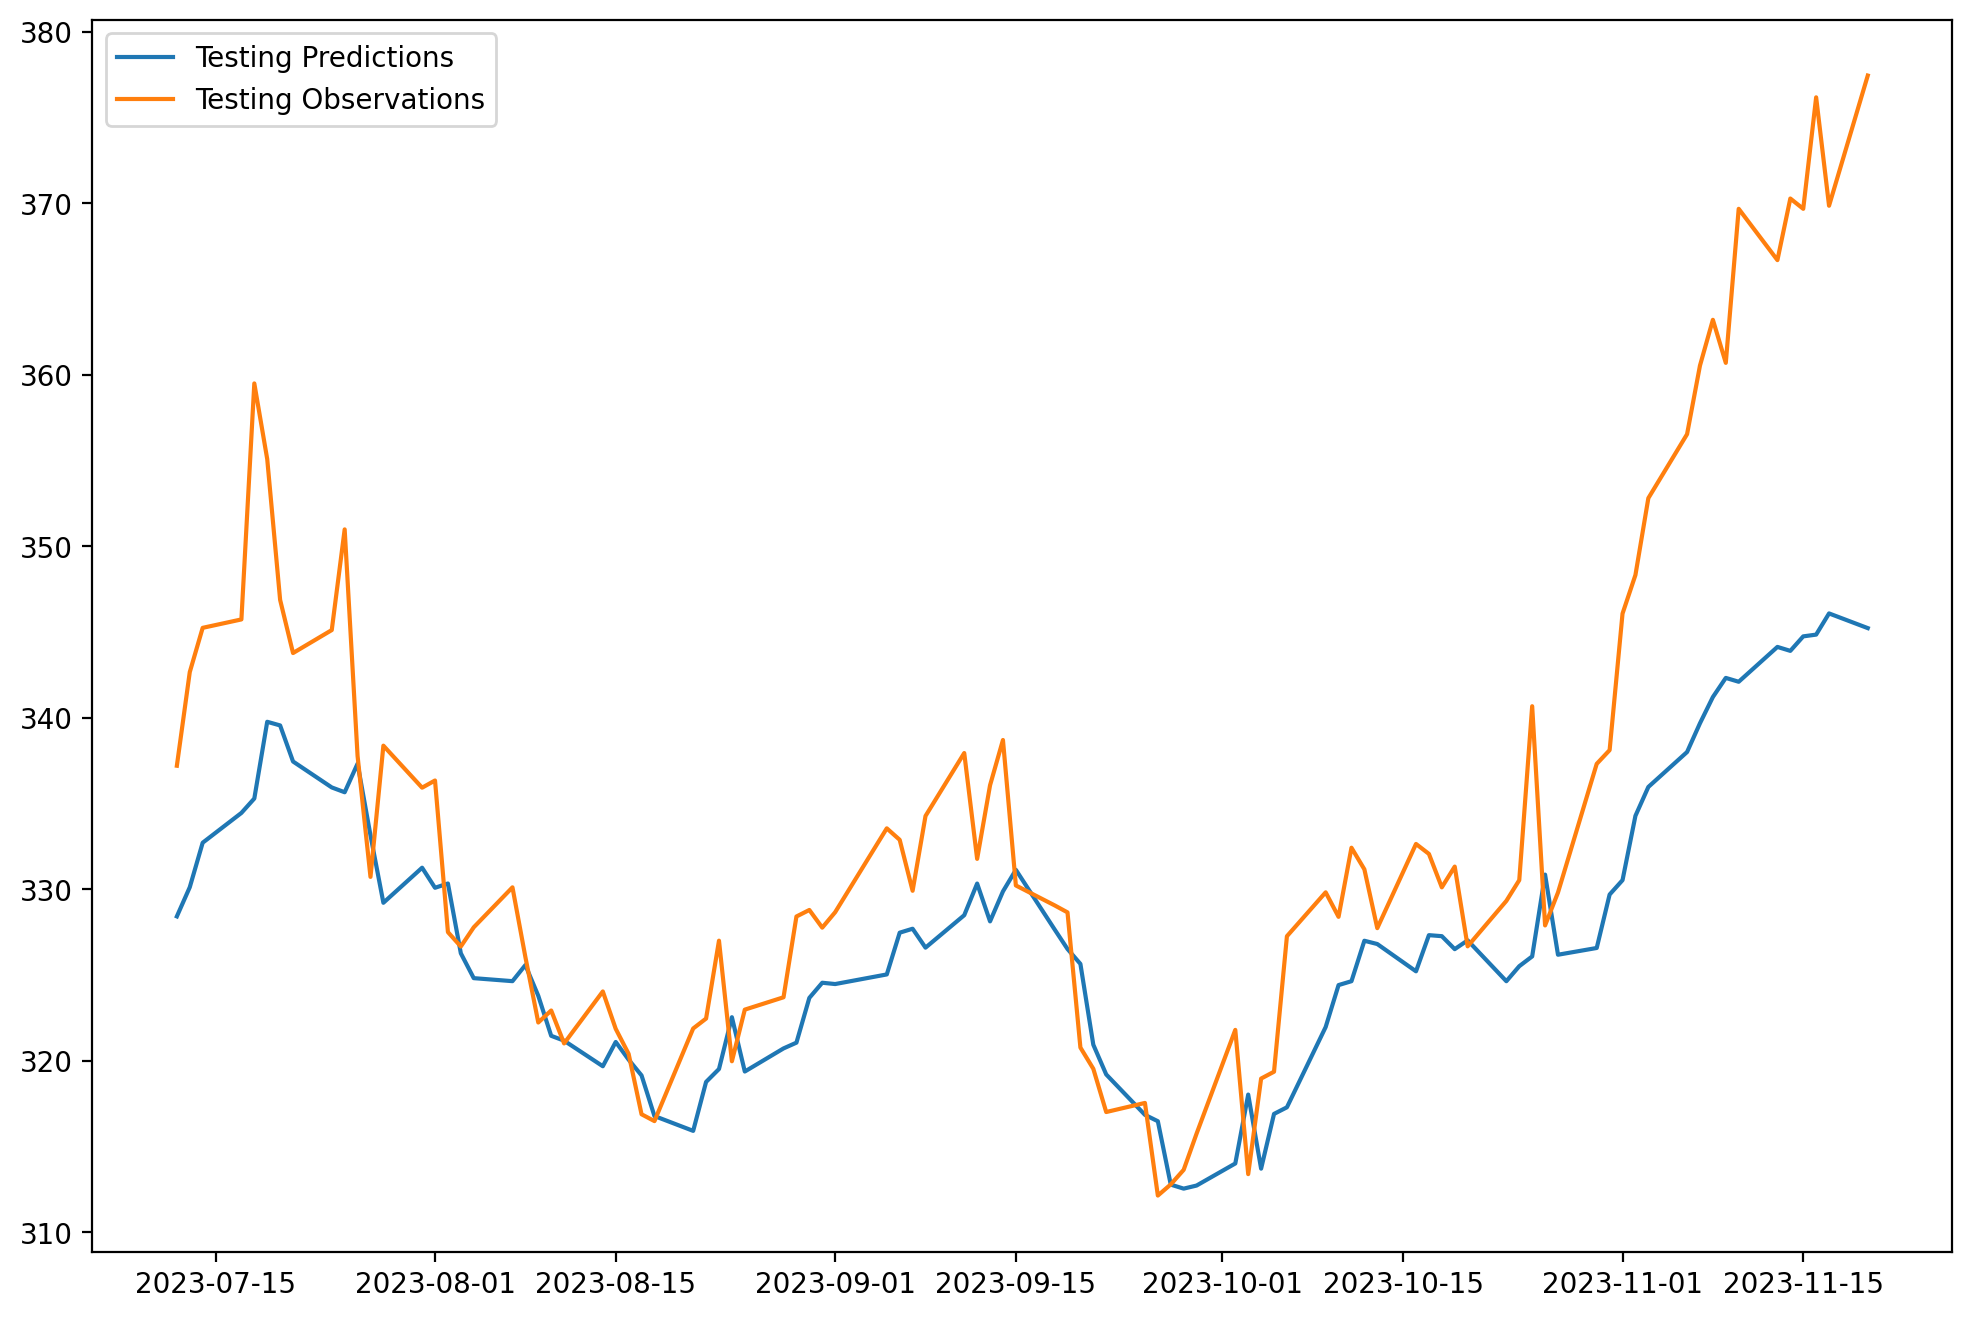

In [17]:
test_predictions = model.predict(X_test).flatten()

plt.figure(figsize=(12, 8), dpi=200)
plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.legend(['Testing Predictions', 'Testing Observations'])

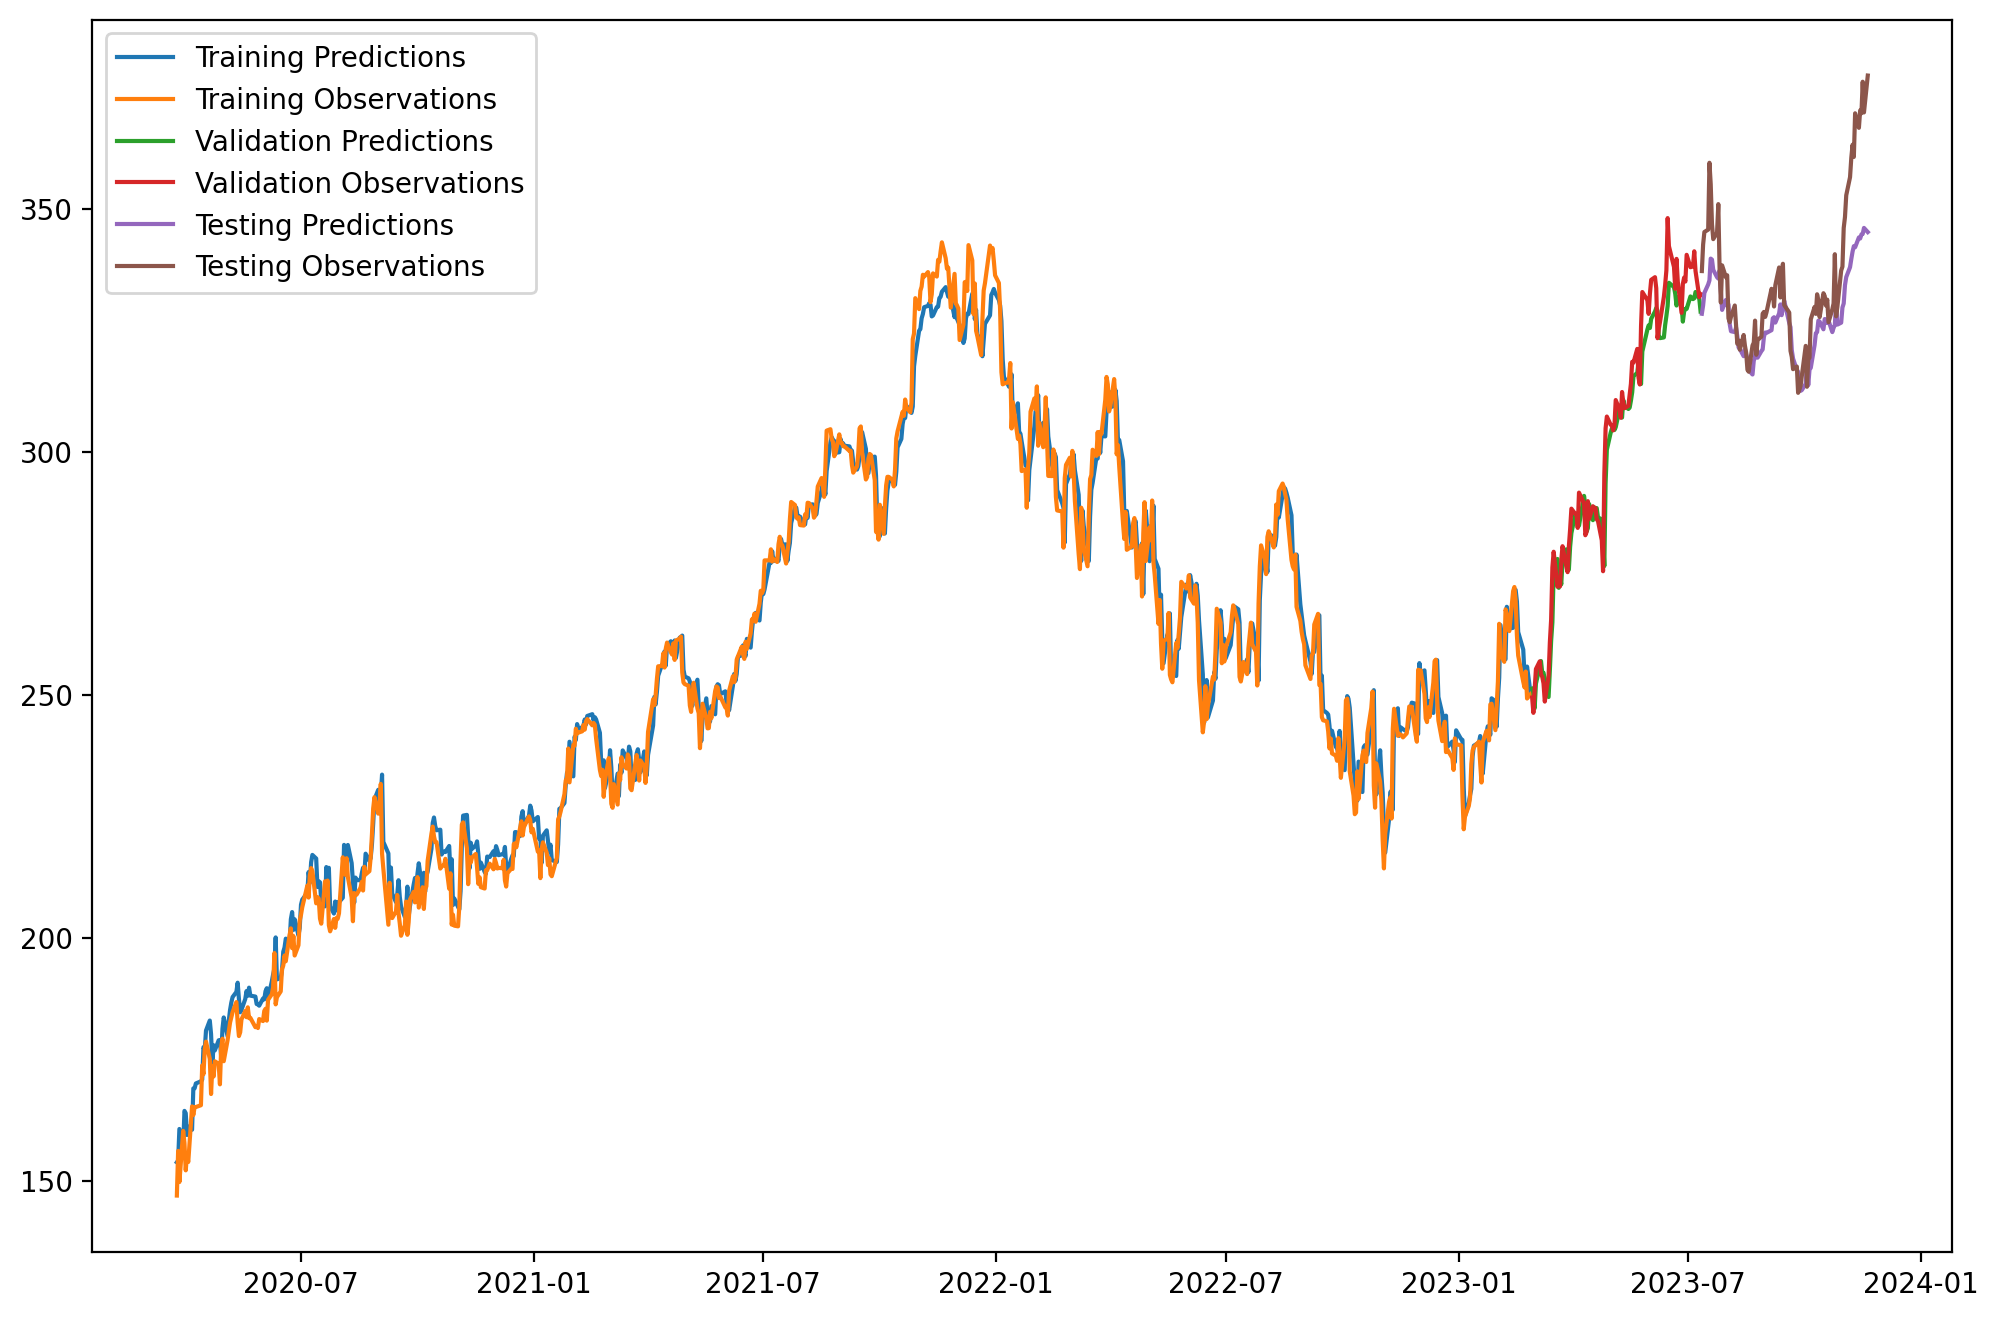

In [18]:
plt.figure(figsize=(12, 8), dpi=200)
plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.legend(['Training Predictions', 
            'Training Observations',
            'Validation Predictions', 
            'Validation Observations',
            'Testing Predictions', 
            'Testing Observations'])

## Make a recursive prediction

Use the predicted data as the input to forecast further result

In [19]:
from copy import deepcopy

recursive_predictions = []
recursive_dates = np.concatenate([dates_val,dates_test])

## Pick the last windows to make prediction
last_window = deepcopy(X_train[-1])

for target_date in recursive_dates:
    next_prediction = model.predict(np.array([last_window])).flatten()
    recursive_predictions.append(next_prediction)
    
    ## update last window use predicted value
    # break
    last_window[:-1] = last_window[1:]
    last_window[-1] = next_prediction
    


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 17ms/step


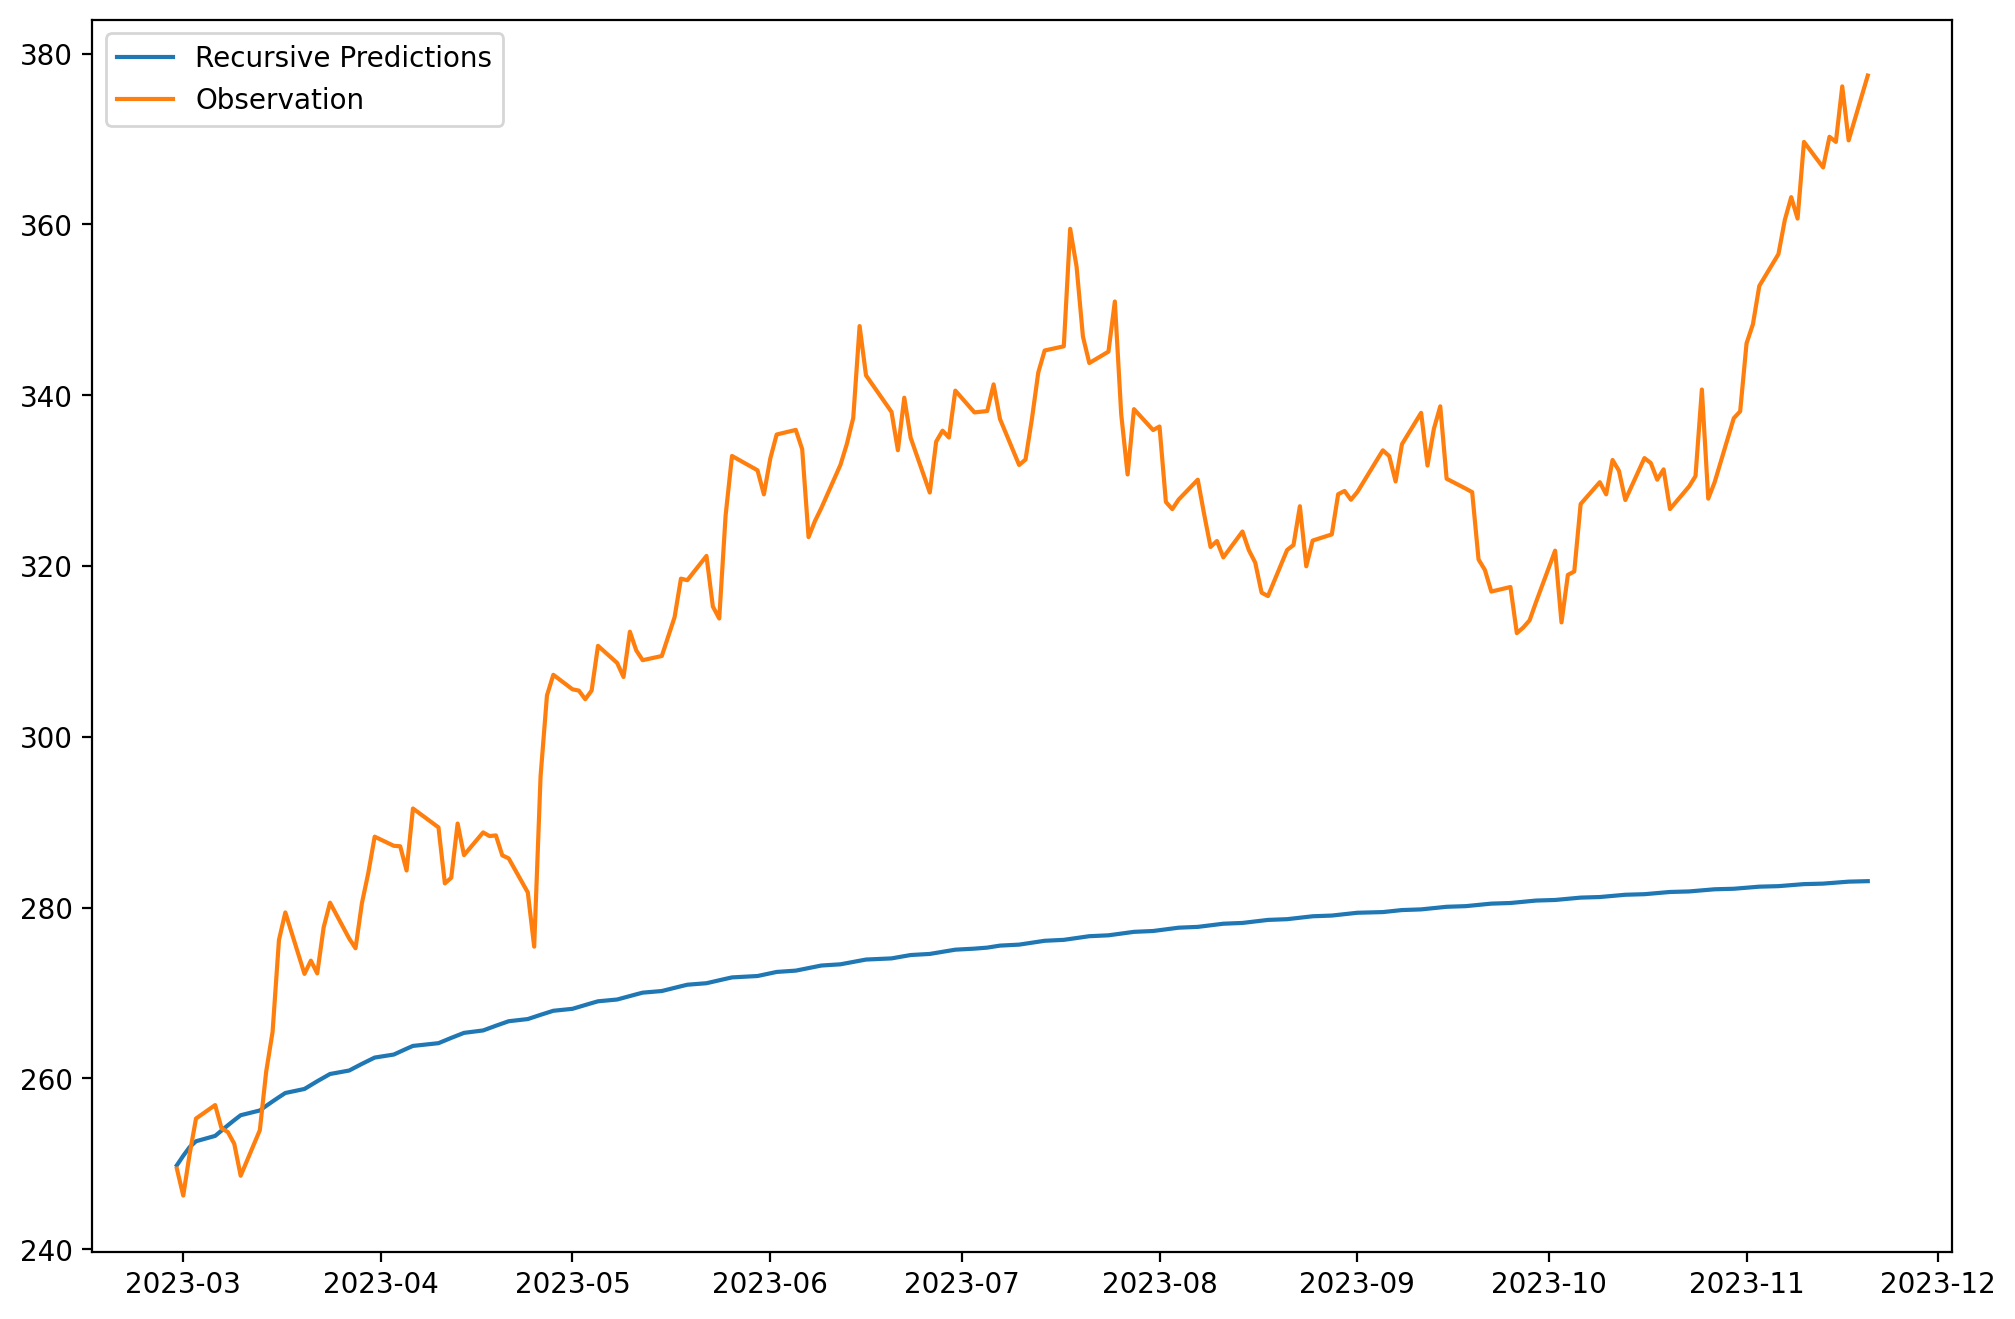

In [20]:
plt.figure(figsize=(12, 8), dpi=200)
plt.plot(recursive_dates, recursive_predictions)
plt.plot(recursive_dates, np.concatenate([y_val,y_test]))

plt.legend(['Recursive Predictions','Observation'])
plt.show() 